---
# <div align="center"><font color='green'> COSC 2673/2793 | Machine Learning  </font></div>
## <div align="center"> <font color='green'> Week 4 Lab Exercises: **Training a Regression Model**</font></div>
---

# Introduction

During the last couple of weeks we learned about how to read data, do exploratory data analysis (EDA) and prepare data for training. The next step in a typical machine learning pipeline is to train the model and to investigate the results. 

The lab assumes that you have completed the labs for week 2 and 3. If you havent yet, please do so before attempting this lab. 

The lab can be executed on either your own machine (with anaconda installation) or on AWS educate classroom setup for the course. 
- Please refer canvas for instructions on installing anaconda python or setting up AWS Sagemaker notebook: [Introduction to Amazon Web Services (AWS) Classrooms](https://rmit.instructure.com/courses/79534/pages/introduction-to-amazon-web-services-aws-classrooms?module_item_id=2952364)


## Objective
- Continue to familiarise with Python and other ML packages
- Learn to train a model for regression and complete the introduction to model development pipeline.
- Learn to investigate the predictions and the developed model. 


## Dataset

We examine two regression datasets in this lab. The first one is to do with house prices, some factors
associated with the prices and trying to predict house prices. The second dataset is predicting the amount of
share bikes hired every day in Washington D.C., USA, based on time of the year, day of the week and weather
factors. These datasets are available in `housing.data.csv` and `bikeShareDay.csv` in the code repository. 

First, ensure the two data files are located within the Jupyter workspace. 
- If you are on the local machine copy the two data data directories (`BostonHousingPrice`,`Bike-Sharing-Dataset`) to your current folder.
- If you are on AWS you can upload the data to the notebook instance by clicking the `upload files` icon on the left sidebar.

# Problem Formulation

The first step in developing a model is to formulate the problem in a way that we can apply machine learning. To reiterate, the `task` in the Boston house price dataset is to predict the house price (`MEDV`), using some attributes of the house and neighbourhood. 

<span style="font-size:1.5em;">�</span> Observe the data and see if there is a pattern that would allow us to predict the house price using the attributes given? You can use the observations from the EDA for this.

<span style="font-size:1.5em;">�</span> What category does the task belong to?
> <span style="font-size:1em;">✔</span> **Task category:** 
> - supervised, multivariate regression 

Given that the attributes and the target is available to us (if not we have to source them), the next item is to establish the performance measure. 

<span style="font-size:1.5em;">�</span> What would be a suitable performance measure for this problem?

> <span style="font-size:1em;">✔</span> **Performance measures:** 
> We will cover the performance measures in lecture 4. For this we will select:
> - R^2 error: It is intuitive compared to MSE - computes how good our regression model as compared to a very simple model that just predicts the mean value of target from the train set as predictions
> - We should use the insights gained from observing the data (EDA) in selecting the performance measure. e.g. are there outliers in target?, 


# Load the dataset and pre-process

Use the knowledge obtained in the last couple of weeks to load the Boston house price data set and pre-process the data (feature scaling, data splitting). 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

bostonHouseFrame = pd.read_csv('./BostonHousingPrice/housing.data.csv', delimiter='\s+')
bostonHouseFrame.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

We can now separate the target and the attributes

In [2]:
bostonHouse_X = bostonHouseFrame.drop(['MEDV'], axis=1)
bostonHouse_y = bostonHouseFrame['MEDV']

Hold out some data for validation

In [3]:
from sklearn.model_selection import train_test_split

with pd.option_context('mode.chained_assignment', None):
    bostonHouse_X_train, bostonHouse_X_test, bostonHouse_y_train, bostonHouse_y_test = train_test_split(bostonHouse_X, bostonHouse_y, test_size=0.2, shuffle=True)

In [7]:
logNorm_attributes = ['CRIM','NOX','AGE','DIS','LSTAT']
minmax_attributes = list(set(bostonHouse_X.columns).difference(set(logNorm_attributes)))
bostonHouse_X_train_scaled = bostonHouse_X_train.copy()
bostonHouse_X_train_scaled.loc[:, minmax_attributes]

TAX    ZN  RAD  INDUS       B  CHAS  PTRATIO     RM
103  384.0   0.0    5   8.56  394.47     0     20.9  6.137
35   279.0   0.0    5   5.96  396.90     0     19.2  5.933
281  216.0  20.0    5   3.33  392.23     0     14.9  6.968
115  432.0   0.0    6  10.01  344.91     0     17.8  5.928
450  666.0   0.0   24  18.10    0.32     0     20.2  6.749
..     ...   ...  ...    ...     ...   ...      ...    ...
476  666.0   0.0   24  18.10  396.21     0     20.2  6.484
211  277.0   0.0    4  10.59  395.24     1     18.6  5.404
251  330.0  22.0    7   5.86  377.07     0     19.1  6.438
403  666.0   0.0   24  18.10  396.90     0     20.2  5.349
324  287.0   0.0    5   7.38  396.90     0     19.6  6.415

[404 rows x 8 columns]

Do feature scaling

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

logNorm_attributes = ['CRIM','NOX','AGE','DIS','LSTAT']
minmax_attributes = list(set(bostonHouse_X.columns).difference(set(logNorm_attributes)))

bostonHouse_X_train_scaled = bostonHouse_X_train.copy()
bostonHouse_X_test_scaled = bostonHouse_X_test.copy()

minmaxscaler = MinMaxScaler().fit(bostonHouse_X_train_scaled.loc[:, minmax_attributes])
bostonHouse_X_train_scaled.loc[:, minmax_attributes] = minmaxscaler.transform(bostonHouse_X_train_scaled.loc[:, minmax_attributes])
bostonHouse_X_test_scaled.loc[:, minmax_attributes] = minmaxscaler.transform(bostonHouse_X_test_scaled.loc[:, minmax_attributes])

powertransformer = PowerTransformer(method='yeo-johnson', standardize=False).fit(bostonHouse_X_train.loc[:, logNorm_attributes])
bostonHouse_X_train_scaled.loc[:, logNorm_attributes] = powertransformer.transform(bostonHouse_X_train.loc[:, logNorm_attributes])
bostonHouse_X_test_scaled.loc[:, logNorm_attributes] = powertransformer.transform(bostonHouse_X_test.loc[:, logNorm_attributes])

minmaxscaler_pt = MinMaxScaler().fit(bostonHouse_X_train_scaled.loc[:, logNorm_attributes])
bostonHouse_X_train_scaled.loc[:, logNorm_attributes] = minmaxscaler_pt.transform(bostonHouse_X_train_scaled.loc[:, logNorm_attributes])
bostonHouse_X_test_scaled.loc[:, logNorm_attributes] = minmaxscaler_pt.transform(bostonHouse_X_test_scaled.loc[:, logNorm_attributes])

Plot features to see if everthing is in order.

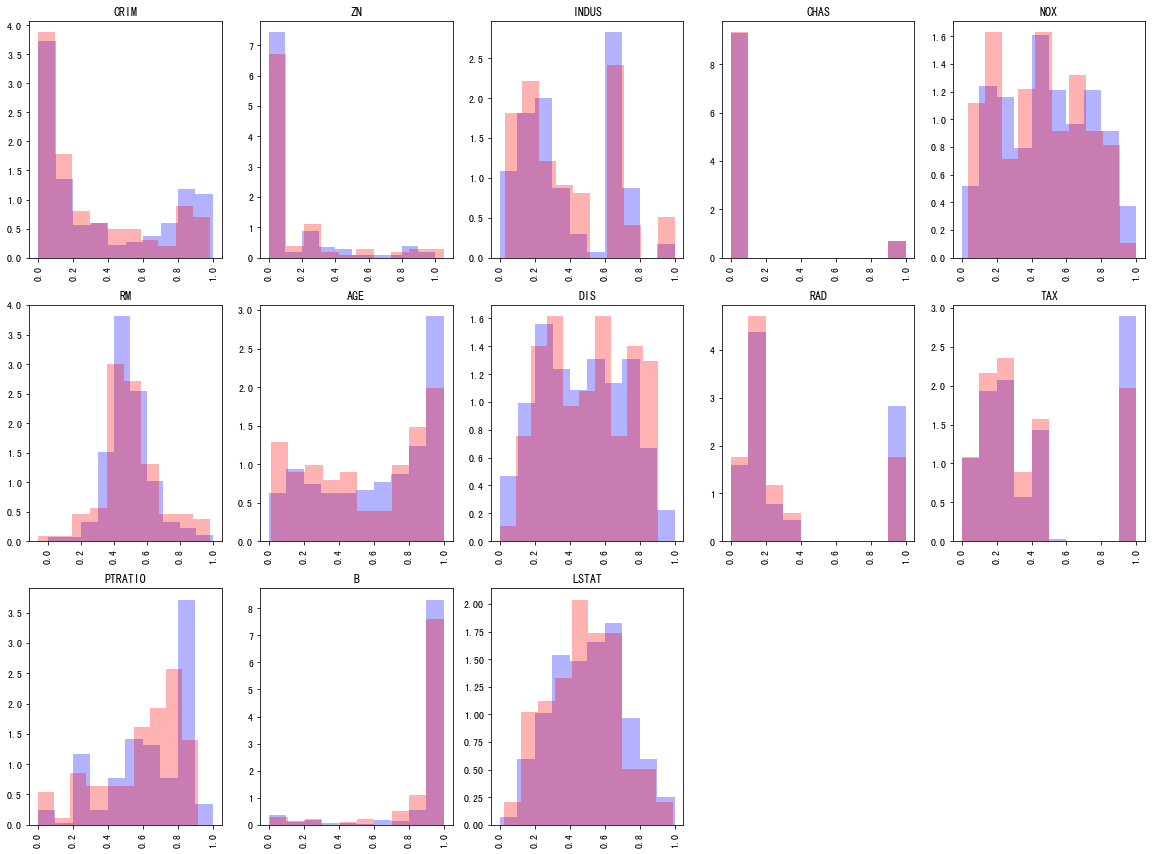

In [9]:
plt.figure(figsize=(20,20))
for i, col in enumerate(bostonHouse_X_train_scaled.columns):
    plt.subplot(4,5,i+1)
    plt.hist(bostonHouse_X_train_scaled[col], alpha=0.3, color='b', density=True)
    plt.hist(bostonHouse_X_test_scaled[col], alpha=0.3, color='r', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')

Now we have prepared our dataset and are ready to build models.

# Building a regression model

We have already established that the task is regression and R^2 as the performance measure. When developing a model we would first want to establish a reasonable baseline model. 

<span style="font-size:1.5em;">�</span> What would be a reasonable baseline for this problem?

> <span style="font-size:1em;">✔</span> **Baseline model:** 
> We can select a linear regression model as a baseline model.
> - During the EDA we observed that some attributes (e.g. 'RM') have a linear relationship with the target value. 
> - Linear model is a simple model that is intuitive.

Lets fit (train) a linear regression model to our scaled training data using the `LinearRegression` in scikit-learn. Read the documentation of [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to understand all the parameters. 

In [10]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression().fit(bostonHouse_X_train_scaled, bostonHouse_y_train)

The function `LinearRegression.fit()` does all the optimizations (training) we discussed in the lecture under the hood and produces the optimal model (parameters or weights). We can print the parameter of the fitted model.

In [11]:
print("Parameter of the Linear model: ", model_lr.coef_)
print("Intercept of the Linear model: ", model_lr.intercept_)

Parameter of the Linear model:  [ -1.33777476   0.85414647   1.27900811   2.50352894  -9.67826476
  10.24487066   2.80732594 -12.90997505   6.13163982  -6.63767253
  -8.18912572   3.14678426 -28.19068653]
Intercept of the Linear model:  43.16775653823847


We can now use the trained model to obtain predictions to unseen data. This process is called prediction.

In [12]:
bostonHouse_y_test_pred = model_lr.predict(bostonHouse_X_test_scaled)

Array `bostonHouse_y_test_pred` contains the predictions made by the model. How does it compare with the "actual" house prices for the test set. Lets first visually observe. 

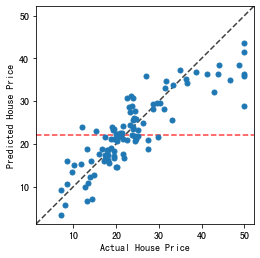

In [13]:
fig, ax = plt.subplots()
ax.scatter(bostonHouse_y_test, bostonHouse_y_test_pred, s=25, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.plot(lims, [np.mean(bostonHouse_y_train),]*2, 'r--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.xlabel('Actual House Price')
plt.ylabel('Predicted House Price')

plt.show()

<span style="font-size:1.5em;">�</span> What observations did you make?

> <span style="font-size:1em;">✔</span> **Observations:** 
> - The model has been able to reasonably predict the house price of unseen examples.
> - It performs better that a simple model that just predicts the mean value of target (red line)

Let's obtain quantitative values of performance.

In [14]:
from sklearn.metrics import r2_score

r2_lr = r2_score(bostonHouse_y_test, bostonHouse_y_test_pred)
print('The R^2 score for the linier regression model is: {:.3f}'.format(r2_lr))


The R^2 score for the linier regression model is: 0.739


<span style="font-size:1.5em;">�</span> How would you interpret the results?

Discuss this with the tutor.

<span style="font-size:1.5em;">�</span> Is there an advantage of using feature scaling? Let's do a simple experiment by fitting a regression model to un-scaled data.

In [15]:
model_us_lr = LinearRegression().fit(bostonHouse_X_train, bostonHouse_y_train)
bostonHouse_y_test_us_pred = model_us_lr.predict(bostonHouse_X_test)

r2_us_lr = r2_score(bostonHouse_y_test, bostonHouse_y_test_us_pred)
print('The R^2 score for the linier regression model (without feature scaling) is: {:.3f}'.format(r2_us_lr))

The R^2 score for the linier regression model (without feature scaling) is: 0.678


Next week we will explore more of the model building phase. For now let's assume that we are happy with the performance of the linear regression model. 

# Explanatory Model Analysis

We now have a model that can predict the house prices reasonably. However at the moment it is a black box: "We feed in the attributes and it will provide a prediction". The test set measurements have provided us some empirical evidence that the model performs reasonably well on unseen examples. 

Is this empirical evidence adequate to trust the model? Do you think the model has picked up a pattern in data that is reasonable and generalizable or has it picked up some accidental property in the dataset which enables it to do well on the data we have collected so far? 

To answer such questions we need to investigate the model closely. Unfortunately we are not yet ready (theoretically) to explore all the options in terms of understanding a model. Let's see a few basic techniques that we can use to investigate a model. 

## Residual plots

We have already used one technique (prediction vs actual plot). Another common tool that can be used to explore a model is to plot the residuals (deviation from the actual value). 

/home/ubuntu/anaconda3/envs/ML/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


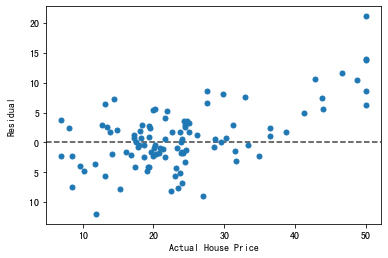

In [16]:
fig, ax = plt.subplots()
ax.scatter(bostonHouse_y_test, bostonHouse_y_test-bostonHouse_y_test_pred, s=25, cmap=plt.cm.coolwarm, zorder=10)

xlims = ax.get_xlim()
ax.plot(xlims, [0.0,]*2, 'k--', alpha=0.75, zorder=0)
ax.set_xlim(xlims)

plt.xlabel('Actual House Price')
plt.ylabel('Residual')

plt.show()

> **<span style="font-size:1.5em;">⚠</span> Warning: The test set should be used for this analysis. Train set may be over-fitted to data**

<span style="font-size:1.5em;">�</span> What observations did you make?

> <span style="font-size:1em;">✔</span> **Observations:** 
> For most models, residuals should express a random behavior with certain properties (like, e.g., being concentrated around 0). If we find any systematic deviations from the expected behavior, they may signal an issue with a model (e.g. plot shows a nonlinear pattern, residual in some parts of the plot is much larger/smaller to others).

There are several other types of residual plots

> **<font color='red'><span style="font-size:1.5em;">☞</span> Additional Reference: Familiarize yourself with model residual based diagnostic plots .</font>**  
> - [Understanding Diagnostic Plots for Linear Regression Analysis](https://data.library.virginia.edu/diagnostic-plots/)
> - [Creating Diagnostic Plots in Python](https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/): uses statsmodel, see if you convert them to scikit learn models

## Feature importance

Another key technique used to investigate simple models is feature importance. Here we estimate how much each feature contributed towards the final prediction value. For linear models this is straightforward. We can simply look at the model coefficients.

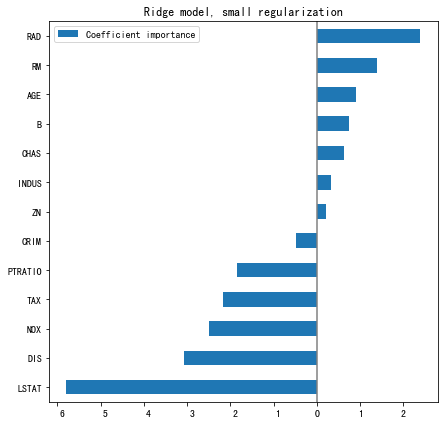

In [17]:
coefs = pd.DataFrame(
    model_lr.coef_  * bostonHouse_X_train_scaled.std(axis=0),
    columns=['Coefficient importance'], index=bostonHouse_X_train_scaled.columns
)
coefs.sort_values(by=['Coefficient importance']).plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model, small regularization')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Looking at the coefficient plot to gauge feature importance can be misleading as some of them vary on a small scale, while others (if unscaled).


> **<span style="font-size:1.5em;">⚠</span> Warning: Coefficients must be scaled to the same unit of measure to retrieve feature importance. Scaling them with the standard-deviation of the feature is a useful proxy.**

> **<span style="font-size:1.5em;">⚠</span> Warning: Correlated features induce instabilities in the coefficients of linear models and their effects cannot be well teased apart.**


<span style="font-size:1.5em;">�</span> What observations did you make?

> <span style="font-size:1em;">✔</span> **Observations:** 
> - Number of rooms and accessibility to highways are highly important towards increasing the predicted price.
> - `lower status of the population`, `distances to employment centres`, `nitric oxides concentration`, `property-tax rate` tend to decrease the predicted price.
> - the relationship between `property-tax rate` and house price is of concern (not what we expect). This is because in the dataset there are many industrial areas with high TAX. If we are to do feature selection, we would have dropped this feature on the evidence we have. 
> - `ZN` and `INDUS` are not very important for house price prediction. 
> - ...

Another parallel technique in scikit-learn for model inspection is Permutation feature importance: a model inspection technique that can be used for any fitted estimator when the data is tabular. More details are provided in [scikit-learn documentation](https://scikit-learn.org/stable/modules/permutation_importance.html#:~:text=The%20permutation%20feature%20importance%20is,model%20depends%20on%20the%20feature.)

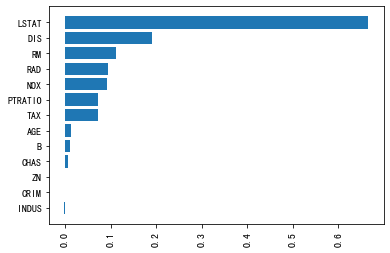

In [18]:
from sklearn.inspection import permutation_importance

r = permutation_importance(model_lr, bostonHouse_X_test_scaled, bostonHouse_y_test, n_repeats=30)
inx = np.argsort(r.importances_mean)

plt.barh(bostonHouse_X_test_scaled.columns[inx], r.importances_mean[inx])
plt.xticks(rotation='vertical')
plt.show()

<span style="font-size:1.5em;">�</span> Is permutation importance same as plotting regression coefficients?

There are many other techniques to inspect models. We will learn more during the course.

# Exercise: Analyse the Bike Share Data

> **<font color='red'><span style="font-size:1.5em;">☞</span> Task: Develop a linear regression model the Bike Share Data.</font>**  
> Now you see how to do this task for the house price dataset. Repeat the same process for the Daily
Bike Share rental data.

> Answer the following questions and discuss this with your lab demonstrator. Please do attempt this, and don’t wait to see if solutions are released (they will not be!)
> - What are the appropriate performance measure for this task?
> - What is a suitable baseline model?
> - What is the performance of the baseline model and is it adequate?
> - Can you trust your model?
